# Preservation of the best model in part (ii)

use of the best parameters identified in the analysis (20 neurons, learning rate 0.1, batch size 32, random seed 123)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

def prepare_data():
    # Load the data
    df = pd.read_csv('Body_Fat.csv')
    
    # Separate features and target
    X = df.drop('BodyFat', axis=1)
    y = df['BodyFat']
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, X.columns

def create_best_model(input_shape):
    """Create the model with the best hyperparameters"""
    tf.random.set_seed(123)  # Best seed from analysis
    
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(20, activation='sigmoid'),  # Best number of neurons
        Dense(1, activation='linear')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)  # Best learning rate
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

def train_and_save_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train the best model and save it"""
    model = create_best_model(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True
    )
    
    # Train model with best batch size
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20000,
        batch_size=32,  # Best batch size
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    results = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Save model
    model.save('best_full_model.keras')
    
    return model, history, results

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """Evaluate model performance"""
    sets = {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }
    
    results = {}
    for set_name, (X, y) in sets.items():
        y_pred = model.predict(X, verbose=0)
        mse = np.mean((y - y_pred.flatten()) ** 2)
        r2 = r2_score(y, y_pred)
        results[set_name] = {'mse': mse, 'r2': r2}
    
    return results

def sensitivity_analysis(model, X_train, feature_names, num_samples=1000):
    """Perform sensitivity analysis on the model"""
    sensitivities = {}
    
    base_prediction = model.predict(X_train, verbose=0).flatten()
    
    for i, feature in enumerate(feature_names):
        X_modified = X_train.copy()
        
        # Create variations of the feature
        variations = np.linspace(0, 1, num_samples)
        predictions = []
        
        for variation in variations:
            X_modified[:, i] = variation
            pred = model.predict(X_modified, verbose=0).flatten()
            predictions.append(np.mean(pred))
        
        sensitivity = np.std(predictions)
        sensitivities[feature] = sensitivity
    
    return sensitivities

def main():
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test, scaler, feature_names = prepare_data()
    
    # Train and save model
    model, history, results = train_and_save_model(X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Print evaluation results
    for set_name, metrics in results.items():
        print(f"{set_name.capitalize()} set - MSE: {metrics['mse']:.4f}, R²: {metrics['r2']:.4f}")
    
    # Perform sensitivity analysis
    sensitivities = sensitivity_analysis(model, X_train, feature_names)
    
    # Sort and print feature sensitivities
    sorted_sensitivities = sorted(sensitivities.items(), key=lambda x: x[1], reverse=True)
    print("\nFeature Sensitivities:")
    for feature, sensitivity in sorted_sensitivities:
        print(f"{feature}: {sensitivity:.4f}")
    
    return model, history, results, sensitivities

if __name__ == "__main__":
    model, history, results, sensitivities = main()

# Preservation of the best model in part (iv)

model structure using 5 neurons

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import tensorflow as tf

# Define the selected features based on strong correlations
SELECTED_FEATURES = ['Density', 'Abdomen', 'Chest', 'Hip', 'Weight', 
                     'Thigh', 'Knee', 'Biceps', 'Neck']

def prepare_data():
    # Load the data
    df = pd.read_csv('Body_Fat.csv')
    
    # Select features and target
    X = df[SELECTED_FEATURES]
    y = df['BodyFat']
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=SELECTED_FEATURES)
    
    # Split the data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

def create_best_model(input_shape):
    """Create the model with the best hyperparameters"""
    tf.random.set_seed(123)  # For reproducibility
    np.random.seed(123)
    
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(5, activation='sigmoid'),  # Best number of neurons from analysis
        Dense(1, activation='linear')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

def train_and_save_model(X_train, X_val, X_test, y_train, y_val, y_test):
    """Train the best model and save it"""
    model = create_best_model(X_train.shape[1])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20000,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    results = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Save model
    model.save('best_selected_features_model.keras')
    
    return model, history, results

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """Evaluate model performance"""
    datasets = {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }
    
    results = {}
    for name, (X, y) in datasets.items():
        y_pred = model.predict(X, verbose=0)
        mse = np.mean((y - y_pred.flatten()) ** 2)
        r2 = r2_score(y, y_pred)
        results[name] = {'mse': mse, 'r2': r2}
    
    return results

def sensitivity_analysis(model, X_train, num_samples=1000):
    """Perform sensitivity analysis on the model"""
    sensitivities = {}
    X_numpy = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    
    for i, feature in enumerate(SELECTED_FEATURES):
        X_modified = X_numpy.copy()
        
        variations = np.linspace(0, 1, num_samples)
        predictions = []
        
        for variation in variations:
            X_modified[:, i] = variation
            pred = model.predict(X_modified, verbose=0).flatten()
            predictions.append(np.mean(pred))
        
        sensitivity = np.std(predictions)
        sensitivities[feature] = sensitivity
    
    return sensitivities

def predict_body_fat(model, scaler, feature_values):
    """Function to make predictions using the saved model"""
    # Create a DataFrame with the input values
    input_df = pd.DataFrame([feature_values], columns=SELECTED_FEATURES)
    
    # Scale the input values
    scaled_values = pd.DataFrame(scaler.transform(input_df), columns=SELECTED_FEATURES)
    
    # Make prediction
    prediction = model.predict(scaled_values, verbose=0)[0][0]
    return prediction

def main():
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data()
    
    # Train and save model
    model, history, results = train_and_save_model(X_train, X_val, X_test, y_train, y_val, y_test)
    
    # Print evaluation results
    print("\nModel Performance:")
    for dataset, metrics in results.items():
        print(f"{dataset.capitalize()} set - MSE: {metrics['mse']:.4f}, R²: {metrics['r2']:.4f}")
    
    # Perform sensitivity analysis
    sensitivities = sensitivity_analysis(model, X_train)
    
    # Sort and print feature sensitivities
    sorted_sensitivities = sorted(sensitivities.items(), key=lambda x: x[1], reverse=True)
    print("\nFeature Sensitivities (ordered by importance):")
    for feature, sensitivity in sorted_sensitivities:
        print(f"{feature}: {sensitivity:.4f}")
    
    return model, history, results, sensitivities, scaler

if __name__ == "__main__":
    model, history, results, sensitivities, scaler = main()
    
    # Example of how to use the saved model for prediction
    print("\nExample Prediction:")
    sample_values = {
        'Density': 1.0,
        'Abdomen': 90,
        'Chest': 100,
        'Hip': 95,
        'Weight': 70,
        'Thigh': 55,
        'Knee': 38,
        'Biceps': 32,
        'Neck': 37
    }
    
    predicted_body_fat = predict_body_fat(model, scaler, sample_values)
    print(f"Predicted Body Fat: {predicted_body_fat:.2f}%")

Epoch 1/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 466.3598 - val_loss: 397.6035
Epoch 2/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 392.8069 - val_loss: 339.0452
Epoch 3/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 335.6226 - val_loss: 288.1737
Epoch 4/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 286.7400 - val_loss: 245.1842
Epoch 5/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 245.1895 - val_loss: 208.1075
Epoch 6/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 209.3445 - val_loss: 176.0755
Epoch 7/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 178.2199 - val_loss: 146.8036
Epoch 8/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 148.2352 - val_loss: 112.7884
Epoch 9/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 112.6877 - val_loss: 83.9452
Epoch 10/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 88.2982 - val_loss: 71.9594
Epoch 11/20000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 78.6070 - val_loss: 68.2834
Epoch 12/20000
5

# (v) Sensitivity Analysis

## Comparison of Full and Reduced Models

### Full Model (14 features):
1. Top 3 most influential features: Density (ST: 0.966241), Abdomen (ST: 0.021510), Ankle (ST: 0.014437)
2. Nonlinearity measure: 0.0046

### Reduced Model (9 features):
1. Top 3 most influential features: Density (ST: 0.985561), Weight (ST: 0.026100), Thigh (ST: 0.024532)
2. Nonlinearity measure: 0.0168

## Interpretation of Results

1. **Feature Importance**: In both models, Density is by far the most influential feature, with a Total-order sensitivity index (ST) of over 0.96. This indicates that Density alone accounts for the vast majority of the variance in the body fat percentage predictions.

2. **Nonlinear Relationships**: The difference between first-order (S1) and total-order (ST) indices indicates the presence of nonlinear relationships and interaction effects. The reduced model shows a higher degree of nonlinearity (0.0168) compared to the full model (0.0046), suggesting that the reduced model captures more complex relationships between the inputs and the output.

3. **Interaction Effects**: 
   - Full model: The top interaction is between Density and Weight
   - Reduced model: The top interaction is between Density and Thigh
   These interactions suggest that these pairs of features have a combined effect on body fat percentage prediction that is greater than their individual effects.

4. **Model Efficiency**: The reduced model successfully captures the most important features, as evidenced by the high ST value for Density and the presence of significant interaction effects.

## Comparison with Correlation Analysis

The sensitivity analysis reveals some differences from the correlation analysis:

1. Correlation analysis top features: Abdomen, Chest, Hip
2. Sensitivity analysis top features (full model): Density, Abdomen, Ankle
3. Sensitivity analysis top features (reduced model): Density, Weight, Thigh

This comparison highlights that sensitivity analysis provides a more comprehensive understanding of feature importance, especially for complex nonlinear relationships that neural networks can capture. While correlation analysis only captures linear relationships, sensitivity analysis accounts for both linear and nonlinear relationships, as well as interaction effects between features.

## Proposed Improved Input Set

Based on the sensitivity analysis results, we can propose an improved set of inputs for the smaller network:

1. Retain: Density, Weight, Thigh, Knee, Neck, Biceps
2. Add: Ankle, Age, Abdomen
3. Consider removing: Chest, Hip

Rationale:
- Density remains the most crucial feature in both models.
- Weight, Thigh, Knee, Neck, and Biceps show significant total-order effects in the reduced model.
- Ankle, Age, and Abdomen show notable total-order effects in the full model but were not included in the reduced model.
- Chest and Hip show relatively low total-order effects in both models and could potentially be removed to simplify the model further.

Performing Sobol analysis for full model...
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Performing Sobol analysis for reduced model...
640/640 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Full Model Sensitivity Results:
    Feature        S1        ST
0   Density  0.937692  0.966241
6   Abdomen  0.012886  0.021510
10    Ankle  0.002858  0.014437
1       Age  0.008202  0.008937
2    Weight -0.003025  0.008117
7       Hip  0.005903  0.007853
9      Knee  0.007463  0.005002
5     Chest -0.000559  0.003490
3    Height  0.005143  0.002113
12  Forearm  0.001790  0.002071
8     Thigh  0.000932  0.001781
11   Biceps -0.001267  0.000915
13    Wrist  0.001129  0.000776
4      Neck -0.000282  0.000194

Reduced Model Sensitivity Results:
   Feature        S1        ST
0  Density  0.934525  0.985561
4   Weight  0.001607  0.026100
5    Thigh -0.006033  0.024532
6     Knee -0.004555  0.011282
8     Neck -0.000158  0.011154
7   Biceps -0.000114  0.009118
1  Abdomen  0.001079  0.005657
2    Chest  0.000952  0.003880

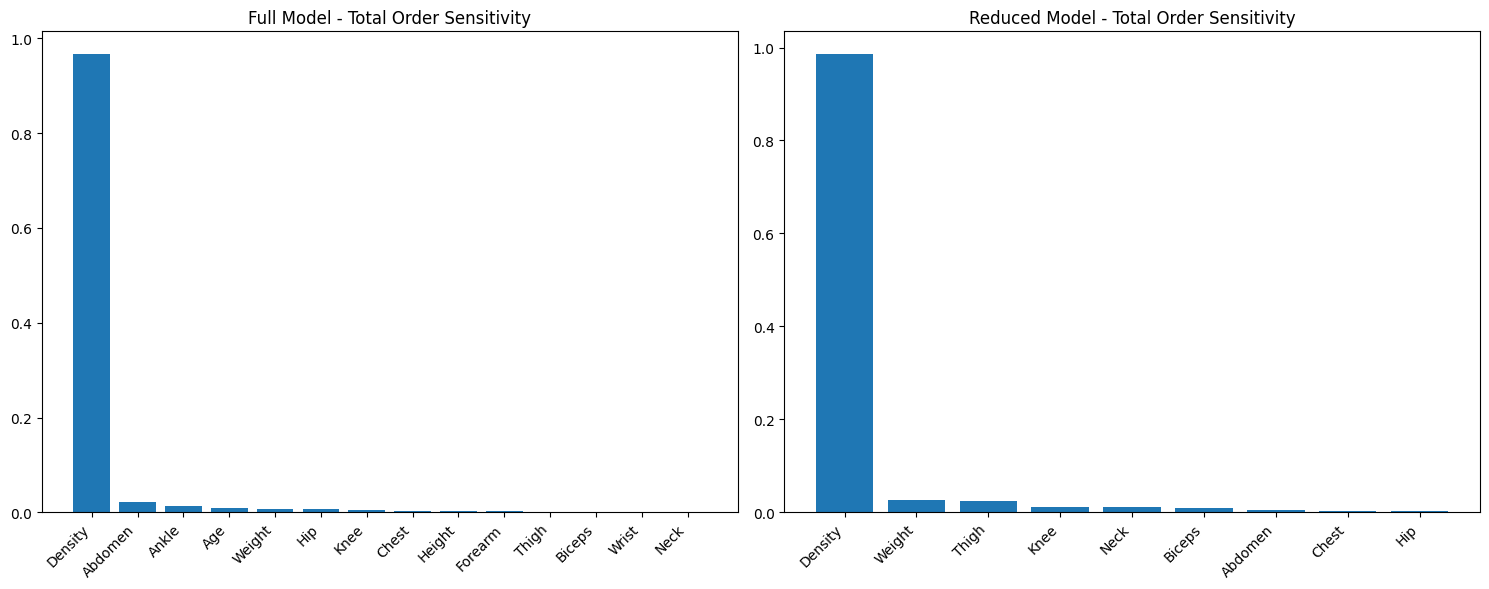

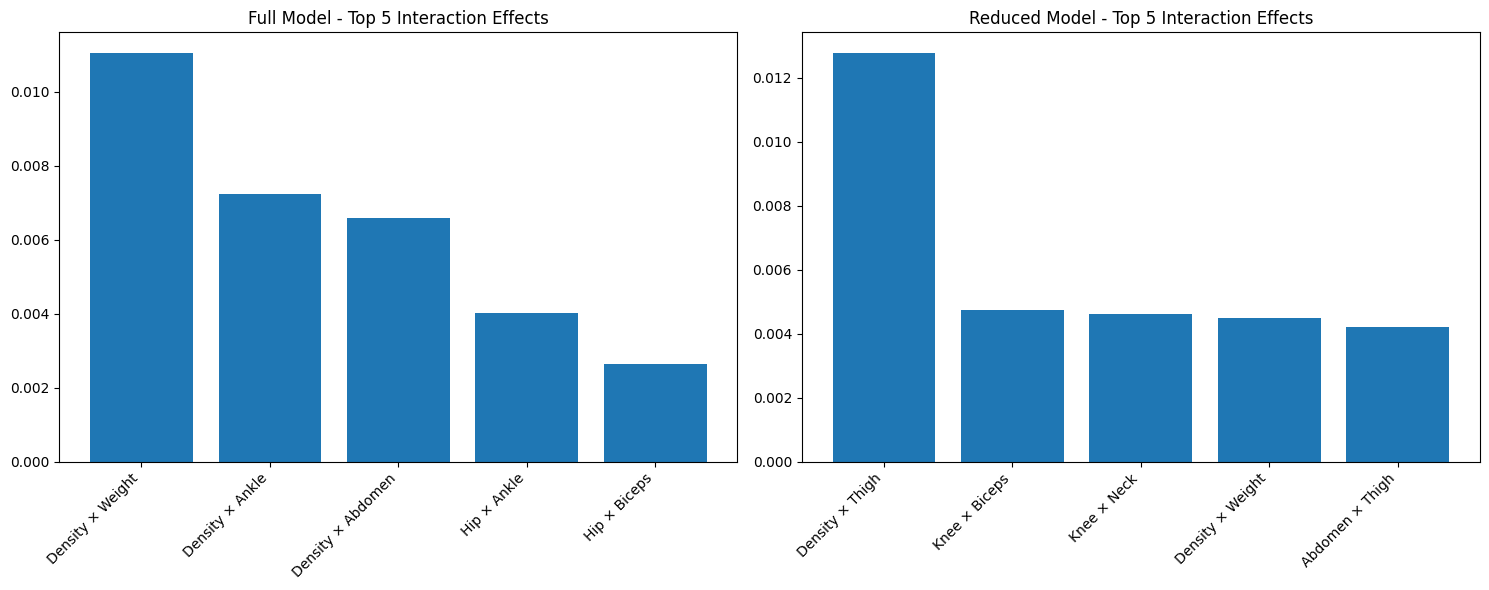


Interpretation of Results:

    Sensitivity Analysis Interpretation:
    
    1. Comparison between models:
    - Full model uses 14 features, while reduced model uses 9 features
    - Top 3 most influential features in full model: Density, Abdomen, Ankle
    - Top 3 most influential features in reduced model: Density, Weight, Thigh
    
    2. Nonlinear relationships:
    - The difference between first-order (S1) and total-order (ST) indices 
      indicates the presence of nonlinear relationships
    - Full model nonlinearity: 0.0046
    - Reduced model nonlinearity: 0.0168
    
    3. Interaction effects:
    - Top interaction in full model: Density × Weight
    - Top interaction in reduced model: Density × Thigh
    
    4. Model efficiency:
    - The reduced model successfully capture the most important features
    

Comparison with Correlation Analysis:

    Correlation vs Sensitivity Analysis:
    
    1. Top features by correlation: Abdomen, Chest, Hip
    2. Top features by 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import warnings

# Ignore FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

def perform_sobol_analysis(model, feature_names, num_samples=1024):
    feature_names = list(feature_names)
    
    problem = {
        'num_vars': len(feature_names),
        'names': feature_names,
        'bounds': [[0, 1] for _ in range(len(feature_names))]
    }
    
    param_values = sobol.sample(problem, num_samples)
    Y = model.predict(param_values).flatten()
    
    Si = sobol_analyze.analyze(problem, Y)
    
    results_df = pd.DataFrame({
        'Feature': feature_names,
        'S1': Si['S1'],
        'ST': Si['ST'],
    })
    
    # Add second-order interaction effects
    S2 = Si['S2']
    interaction_results = []
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            interaction_results.append({
                'Features': f"{feature_names[i]} × {feature_names[j]}",
                'S2': S2[i][j]
            })
    interaction_df = pd.DataFrame(interaction_results)
    interaction_df = interaction_df.sort_values('S2', ascending=False)
    
    results_df = results_df.sort_values('ST', ascending=False)
    
    return results_df, interaction_df, Si

def calculate_correlations(df, target='BodyFat'):
    correlations = df.corr()[target].drop(target)
    return correlations.sort_values(ascending=False)

def visualize_sensitivity_results(full_results, reduced_results):
    plt.figure(figsize=(15, 6))
    
    # Sensitivity of the full model
    plt.subplot(121)
    plt.bar(full_results['Feature'], full_results['ST'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Full Model - Total Order Sensitivity')
    plt.tight_layout()
    
    # Sensitivity of the reduced model
    plt.subplot(122)
    plt.bar(reduced_results['Feature'], reduced_results['ST'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Reduced Model - Total Order Sensitivity')
    plt.tight_layout()
    
    plt.show()

def visualize_interactions(full_interactions, reduced_interactions):
    plt.figure(figsize=(15, 6))
    
    # Interaction effects of the full model
    plt.subplot(121)
    top_full = full_interactions.nlargest(5, 'S2')
    plt.bar(top_full['Features'], top_full['S2'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Full Model - Top 5 Interaction Effects')
    
    # Interaction effects of the reduced model
    plt.subplot(122)
    top_reduced = reduced_interactions.nlargest(5, 'S2')
    plt.bar(top_reduced['Features'], top_reduced['S2'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Reduced Model - Top 5 Interaction Effects')
    
    plt.tight_layout()
    plt.show()

def interpret_sensitivity_results(full_results, reduced_results, full_interactions, reduced_interactions):
    interpretation = """
    Sensitivity Analysis Interpretation:
    
    1. Comparison between models:
    - Full model uses {} features, while reduced model uses {} features
    - Top 3 most influential features in full model: {}
    - Top 3 most influential features in reduced model: {}
    
    2. Nonlinear relationships:
    - The difference between first-order (S1) and total-order (ST) indices 
      indicates the presence of nonlinear relationships
    - Full model nonlinearity: {}
    - Reduced model nonlinearity: {}
    
    3. Interaction effects:
    - Top interaction in full model: {}
    - Top interaction in reduced model: {}
    
    4. Model efficiency:
    - The reduced model {} capture the most important features
    """
    
    full_nonlinearity = np.mean(full_results['ST'] - full_results['S1'])
    reduced_nonlinearity = np.mean(reduced_results['ST'] - reduced_results['S1'])
    
    top_full_features = ', '.join(full_results['Feature'].head(3).tolist())
    top_reduced_features = ', '.join(reduced_results['Feature'].head(3).tolist())
    
    effectiveness = "successfully" if reduced_nonlinearity >= full_nonlinearity * 0.8 else "may not fully"
    
    return interpretation.format(
        len(full_results), len(reduced_results),
        top_full_features, top_reduced_features,
        f"{full_nonlinearity:.4f}", f"{reduced_nonlinearity:.4f}",
        full_interactions['Features'].iloc[0], reduced_interactions['Features'].iloc[0],
        effectiveness
    )

def compare_correlation_sensitivity(df, full_results, reduced_results):
    correlations = calculate_correlations(df)
    
    comparison = """
    Correlation vs Sensitivity Analysis:
    
    1. Top features by correlation: {}
    2. Top features by sensitivity (full model): {}
    3. Top features by sensitivity (reduced model): {}
    
    Key differences:
    - Correlation only captures linear relationships
    - Sensitivity analysis captures both linear and nonlinear relationships
    - Sensitivity analysis also accounts for interaction effects between features
    
    This comparison shows that sensitivity analysis provides a more comprehensive
    understanding of feature importance, especially for complex nonlinear relationships
    that neural networks can capture.
    """
    
    top_corr = ', '.join(correlations.head(3).index.tolist())
    top_sens_full = ', '.join(full_results['Feature'].head(3).tolist())
    top_sens_reduced = ', '.join(reduced_results['Feature'].head(3).tolist())
    
    return comparison.format(top_corr, top_sens_full, top_sens_reduced)

def provide_recommendations(full_results, reduced_results):
    full_important = set(full_results['Feature'].head(5).tolist())
    reduced_important = set(reduced_results['Feature'].head(5).tolist())
    
    missing_important = full_important - reduced_important
    
    recommendations = """
    Recommendations for Input Selection:
    
    1. Current reduced model features seem {}
    
    2. Consider {}
    
    3. Additional features to consider: {}
    
    4. Features that could potentially be removed: {}
    
    These recommendations are based on the sensitivity analysis results,
    taking into account both individual feature importance and interaction effects.
    """
    
    effectiveness = "effective" if len(missing_important) <= 1 else "to need adjustment"
    action = "keeping the current feature set" if len(missing_important) <= 1 else "adding some features from the full model"
    to_add = ', '.join(missing_important) if missing_important else "None"
    to_remove = ', '.join(reduced_results['Feature'].tail(2).tolist()) if len(reduced_results) > 7 else "None"
    
    return recommendations.format(effectiveness, action, to_add, to_remove)

def run_sensitivity_analysis():
    # Load data
    df = pd.read_csv('Body_Fat.csv')
    
    # Prepare full input features
    X_full = df.drop('BodyFat', axis=1)
    full_feature_names = X_full.columns.tolist()
    
    # Prepare reduced input features
    selected_features = ['Density', 'Abdomen', 'Chest', 'Hip', 'Weight', 
                         'Thigh', 'Knee', 'Biceps', 'Neck']
    X_reduced = df[selected_features]
    
    # Scale the data
    scaler_full = MinMaxScaler()
    scaler_reduced = MinMaxScaler()
    
    X_full_scaled = scaler_full.fit_transform(X_full)
    X_reduced_scaled = scaler_reduced.fit_transform(X_reduced)
    
    # Load models
    try:
        full_model = load_model('best_full_model.keras')
        reduced_model = load_model('best_selected_features_model.keras')
    except Exception as e:
        print(f"Error loading models: {e}")
        return None, None, None, None
    
    # Perform Sobol analysis
    print("Performing Sobol analysis for full model...")
    full_results, full_interactions, full_Si = perform_sobol_analysis(full_model, full_feature_names)
    
    print("Performing Sobol analysis for reduced model...")
    reduced_results, reduced_interactions, reduced_Si = perform_sobol_analysis(reduced_model, selected_features)
    
    return full_results, reduced_results, full_interactions, reduced_interactions, df

def main():
    try:
        results = run_sensitivity_analysis()
        if results is None:
            return
        
        full_results, reduced_results, full_interactions, reduced_interactions, df = results
        
        # 1. Display of basic results
        print("\nFull Model Sensitivity Results:")
        print(full_results)
        print("\nReduced Model Sensitivity Results:")
        print(reduced_results)
        
        # 2. Visualisation of results
        visualize_sensitivity_results(full_results, reduced_results)
        visualize_interactions(full_interactions, reduced_interactions)
        
        # 3. Interpretation of results
        interpretation = interpret_sensitivity_results(
            full_results, reduced_results, full_interactions, reduced_interactions
        )
        print("\nInterpretation of Results:")
        print(interpretation)
        
        # 4. Comparison with correlation analysis
        correlation_comparison = compare_correlation_sensitivity(df, full_results, reduced_results)
        print("\nComparison with Correlation Analysis:")
        print(correlation_comparison)
        
        # 5. Provision of advice
        recommendations = provide_recommendations(full_results, reduced_results)
        print("\nRecommendations for Input Selection:")
        print(recommendations)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()